In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score)
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

# For advanced features
from collections import Counter
import pickle
from datetime import datetime

print("✓ All libraries imported successfully")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully
Notebook executed at: 2026-01-11 11:29:44


In [4]:
DATA_PATH = "NASA_TechPort_rows.csv"

try:
    df = pd.read_csv(DATA_PATH)
    print("✓ Dataset loaded successfully\n")
    print(f"Total rows: {df.shape[0]:,}")
    print(f"Total columns: {df.shape[1]}")
    print("\n" + "="*60)
    print("AVAILABLE COLUMNS:")
    print("="*60)
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\n" + "="*60)
    print("DATASET INFO:")
    print("="*60)
    print(df.info())
    
except FileNotFoundError:
    print("⚠ Dataset not found. Please ensure NASA_TechPort_rows.csv is in the working directory")
except Exception as e:
    print(f"⚠ Error loading dataset: {e}")

✓ Dataset loaded successfully

Total rows: 16,897
Total columns: 8

AVAILABLE COLUMNS:
 1. TechPort ID
 2. Project Title
 3. Project Description
 4. Responsible NASA Program
 5. Primary Taxonomy
 6. Project Last Updated
 7. Project URL
 8. Project API URL

DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16897 entries, 0 to 16896
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   TechPort ID               16897 non-null  int64 
 1   Project Title             16897 non-null  object
 2   Project Description       15708 non-null  object
 3   Responsible NASA Program  16897 non-null  object
 4   Primary Taxonomy          16897 non-null  object
 5   Project Last Updated      16897 non-null  object
 6   Project URL               16897 non-null  object
 7   Project API URL           16897 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.0+ MB
None


In [5]:
def find_column(keywords, columns):
    """Find column name matching any of the keywords"""
    for col in columns:
        for key in keywords:
            if key.lower() in col.lower():
                return col
    return None

# Auto-detect columns
title_col = find_column(["title", "name"], df.columns)
abstract_col = find_column(["description", "abstract", "summary"], df.columns)
label_col = find_column(["taxonomy", "category", "area", "domain"], df.columns)

print("DETECTED COLUMNS:")
print("="*60)
print(f"Title Column    : {title_col}")
print(f"Abstract Column : {abstract_col}")
print(f"Label Column    : {label_col}")

if not all([title_col, abstract_col, label_col]):
    print("\n⚠ Warning: Some columns could not be auto-detected")
    print("Please manually specify column names")

DETECTED COLUMNS:
Title Column    : Project Title
Abstract Column : Project Description
Label Column    : Primary Taxonomy


In [6]:
# Cell 4: Data Cleaning and Preprocessing
# Select relevant columns
df_clean = df[[title_col, abstract_col, label_col]].copy()
df_clean.columns = ["title", "abstract", "raw_label"]

print("BEFORE CLEANING:")
print("="*60)
print(f"Total records: {len(df_clean):,}")
print(f"Missing values:\n{df_clean.isnull().sum()}\n")

# Remove missing values
df_clean = df_clean.dropna()

# Filter abstracts with sufficient content (min 80 characters)
df_clean = df_clean[df_clean["abstract"].str.len() > 80]

# Remove duplicates
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['abstract'])
duplicates_removed = initial_count - len(df_clean)

print("AFTER CLEANING:")
print("="*60)
print(f"Records remaining: {len(df_clean):,}")
print(f"Duplicates removed: {duplicates_removed:,}")
print(f"Data retention: {len(df_clean)/len(df)*100:.2f}%")

# Show abstract length statistics
df_clean['abstract_length'] = df_clean['abstract'].str.len()
print("\nABSTRACT LENGTH STATISTICS:")
print(df_clean['abstract_length'].describe())

BEFORE CLEANING:
Total records: 16,897
Missing values:
title           0
abstract     1189
raw_label       0
dtype: int64

AFTER CLEANING:
Records remaining: 15,499
Duplicates removed: 161
Data retention: 91.73%

ABSTRACT LENGTH STATISTICS:
count    15499.000000
mean      1484.647203
std        904.442468
min         81.000000
25%        972.500000
50%       1350.000000
75%       1837.000000
max      23222.000000
Name: abstract_length, dtype: float64



LABEL DISTRIBUTION:
label
General Space Technology       9054
Mission Operations             2221
Instrumentation & Sensors      2215
Propulsion & Power             1495
Earth & Atmospheric Science     376
Human Spaceflight               114
Planetary Science                24
Name: count, dtype: int64

Total categories: 7


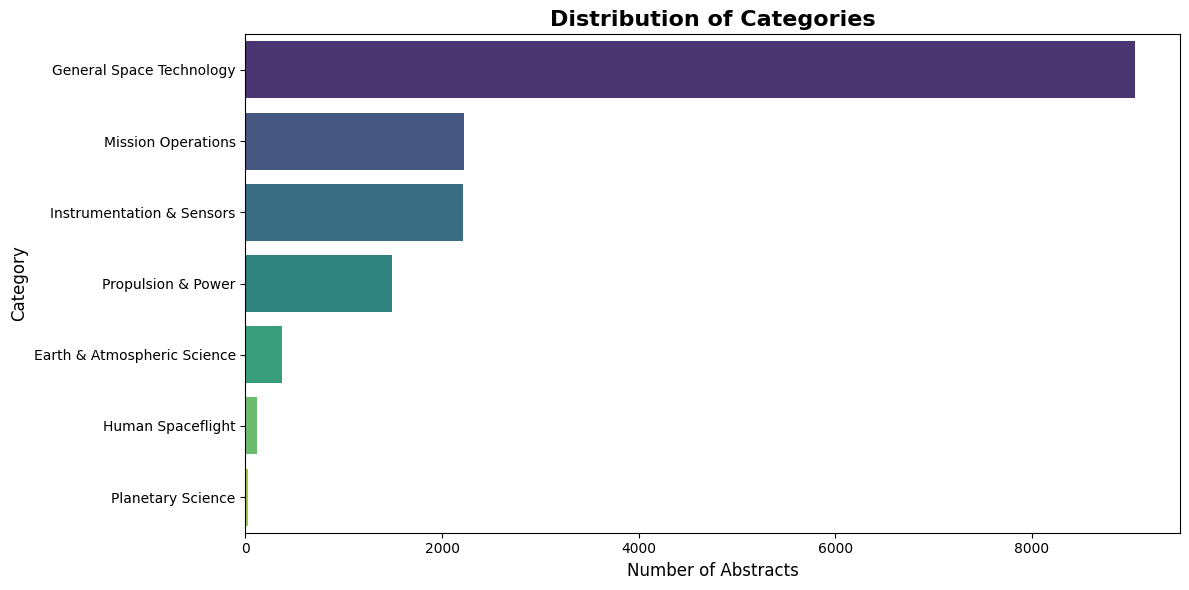

In [7]:
def map_labels_advanced(label):
    """Enhanced label mapping with better categorization"""
    label = str(label).lower()
    
    # Planetary Science
    if any(word in label for word in ['planet', 'mars', 'lunar', 'moon', 'venus', 'jupiter']):
        return "Planetary Science"
    
    # Earth & Atmospheric Science
    elif any(word in label for word in ['earth', 'atmospher', 'climate', 'weather', 'ocean']):
        return "Earth & Atmospheric Science"
    
    # Instrumentation & Sensors
    elif any(word in label for word in ['instrument', 'sensor', 'detector', 'camera', 'spectrometer']):
        return "Instrumentation & Sensors"
    
    # Mission Operations & Systems
    elif any(word in label for word in ['mission', 'system', 'operation', 'spacecraft', 'satellite']):
        return "Mission Operations"
    
    # Propulsion & Power
    elif any(word in label for word in ['propulsion', 'power', 'energy', 'solar', 'nuclear']):
        return "Propulsion & Power"
    
    # Astrophysics & Space Science
    elif any(word in label for word in ['astro', 'star', 'galaxy', 'cosmic', 'universe']):
        return "Astrophysics"
    
    # Human Spaceflight & Habitation
    elif any(word in label for word in ['human', 'crew', 'habitat', 'life support', 'eva']):
        return "Human Spaceflight"
    
    # Default category
    else:
        return "General Space Technology"

df_clean['label'] = df_clean['raw_label'].apply(map_labels_advanced)

# Show label distribution
print("\nLABEL DISTRIBUTION:")
print("="*60)
label_counts = df_clean['label'].value_counts()
print(label_counts)
print(f"\nTotal categories: {df_clean['label'].nunique()}")

# Visualize distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.title('Distribution of Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Abstracts', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()


In [8]:
# Cell 6: Advanced Text Preprocessing
def clean_text_advanced(text):
    """Enhanced text cleaning with scientific text considerations"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Keep alphanumeric, spaces, and basic punctuation
    text = re.sub(r'[^a-z0-9\s.,;:\-]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)
    
    return text.strip()

# Apply cleaning
df_clean['clean_text'] = df_clean['abstract'].apply(clean_text_advanced)

# Show example
print("TEXT CLEANING EXAMPLE:")
print("="*60)
print("ORIGINAL:")
print(df_clean['abstract'].iloc[0][:200], "...\n")
print("CLEANED:")
print(df_clean['clean_text'].iloc[0][:200], "...")


TEXT CLEANING EXAMPLE:
ORIGINAL:
Design&nbsp;and build a LIDAR&nbsp;engineering test unit (AKA -&nbsp;SQRLi) and provide a 35 m or greater range, larger than 40x40 degree field of view at the maximal range, and operation capability u ...

CLEANED:
designnbsp;and build  lidarnbsp;engineering test unit aka -nbsp;sqrli and provide  35  or greater range, larger than 40x40 degree field of view at the maximal range, and operation capability under poo ...


In [9]:
# Cell 7: Split Dataset into Train and Test Sets
# Stratified split to maintain label distribution
X = df_clean['clean_text']
y = df_clean['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("DATASET SPLIT:")
print("="*60)
print(f"Training samples  : {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples   : {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain label distribution:\n{y_train.value_counts()}")
print(f"\nTest label distribution:\n{y_test.value_counts()}")

DATASET SPLIT:
Training samples  : 12,399 (80.0%)
Testing samples   : 3,100 (20.0%)

Train label distribution:
label
General Space Technology       7243
Mission Operations             1777
Instrumentation & Sensors      1772
Propulsion & Power             1196
Earth & Atmospheric Science     301
Human Spaceflight                91
Planetary Science                19
Name: count, dtype: int64

Test label distribution:
label
General Space Technology       1811
Mission Operations              444
Instrumentation & Sensors       443
Propulsion & Power              299
Earth & Atmospheric Science      75
Human Spaceflight                23
Planetary Science                 5
Name: count, dtype: int64


In [11]:
# Cell 8: Feature Extraction with Optimized TF-IDF
# Create TF-IDF vectorizer with optimal parameters
vectorizer = TfidfVectorizer(
    max_features=20000,      # Increase features for better representation
    ngram_range=(1, 3),      # Unigrams, bigrams, and trigrams
    min_df=2,                # Ignore terms in fewer than 2 documents
    max_df=0.8,              # Ignore terms in more than 80% of documents
    stop_words='english',
    sublinear_tf=True,       # Use log scaling
    strip_accents='unicode'
)
# Fit and transform
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF VECTORIZATION:")
print("="*60)
print(f"Vocabulary size      : {len(vectorizer.vocabulary_):,}")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Testing matrix shape : {X_test_tfidf.shape}")
print(f"Matrix sparsity      : {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")

# Show top features
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")

TF-IDF VECTORIZATION:
Vocabulary size      : 20,000
Training matrix shape: (12399, 20000)
Testing matrix shape : (3100, 20000)
Matrix sparsity      : 99.41%

Sample features: ['000', '000 feet', '000 ft', '000 hours', '000 psi', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '10 000', '10 10', '10 100', '10 15', '10 20']


In [12]:
# Cell 9: Train Multiple Models for Comparison
print("TRAINING MULTIPLE MODELS:")
print("="*60 + "\n")

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        C=1.0, 
        class_weight='balanced',
        random_state=42
    ),
    'Multinomial Naive Bayes': MultinomialNB(alpha=0.1),
    'Linear SVM': LinearSVC(
        C=1.0, 
        class_weight='balanced', 
        max_iter=2000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=50,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"  ✓ Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}\n")

# Display results comparison
results_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1']
    }
    for name, res in results.items()
}).T

print("\nMODEL COMPARISON:")
print("="*60)
print(results_df.round(4))

# Find best model
best_model_name = results_df['F1-Score'].idxmax()
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name}")

TRAINING MULTIPLE MODELS:

Training Logistic Regression...
  ✓ Accuracy: 0.6210 | F1-Score: 0.6324

Training Multinomial Naive Bayes...
  ✓ Accuracy: 0.6803 | F1-Score: 0.6517

Training Linear SVM...
  ✓ Accuracy: 0.6684 | F1-Score: 0.6667

Training Random Forest...
  ✓ Accuracy: 0.6594 | F1-Score: 0.5803


MODEL COMPARISON:
                         Accuracy  Precision  Recall  F1-Score
Logistic Regression        0.6210     0.6718  0.6210    0.6324
Multinomial Naive Bayes    0.6803     0.6637  0.6803    0.6517
Linear SVM                 0.6684     0.6668  0.6684    0.6667
Random Forest              0.6594     0.6799  0.6594    0.5803

🏆 Best Model: Linear SVM


In [13]:
# Cell 10: Hyperparameter Tuning for Best Model
print("HYPERPARAMETER TUNING:")
print("="*60 + "\n")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga']
    }
    base_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    
elif best_model_name == 'Linear SVM':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'loss': ['hinge', 'squared_hinge']
    }
    base_model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
    
else:
    param_grid = {'alpha': [0.01, 0.1, 1.0]}
    base_model = MultinomialNB()

# Grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test_tfidf)

HYPERPARAMETER TUNING:

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'C': 0.1, 'loss': 'squared_hinge'}
Best CV score: 0.6740


FINAL MODEL EVALUATION:

Overall Metrics:
Accuracy : 0.6816
Precision: 0.6802
Recall   : 0.6816
F1-Score : 0.6774

CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

Earth & Atmospheric Science       0.37      0.47      0.41        75
   General Space Technology       0.78      0.77      0.78      1811
          Human Spaceflight       0.30      0.48      0.37        23
  Instrumentation & Sensors       0.59      0.71      0.64       443
         Mission Operations       0.48      0.32      0.38       444
          Planetary Science       0.50      0.40      0.44         5
         Propulsion & Power       0.60      0.69      0.64       299

                   accuracy                           0.68      3100
                  macro avg       0.52      0.55      0.52      3100
               weighted avg       0.68      0.68      0.68      3100



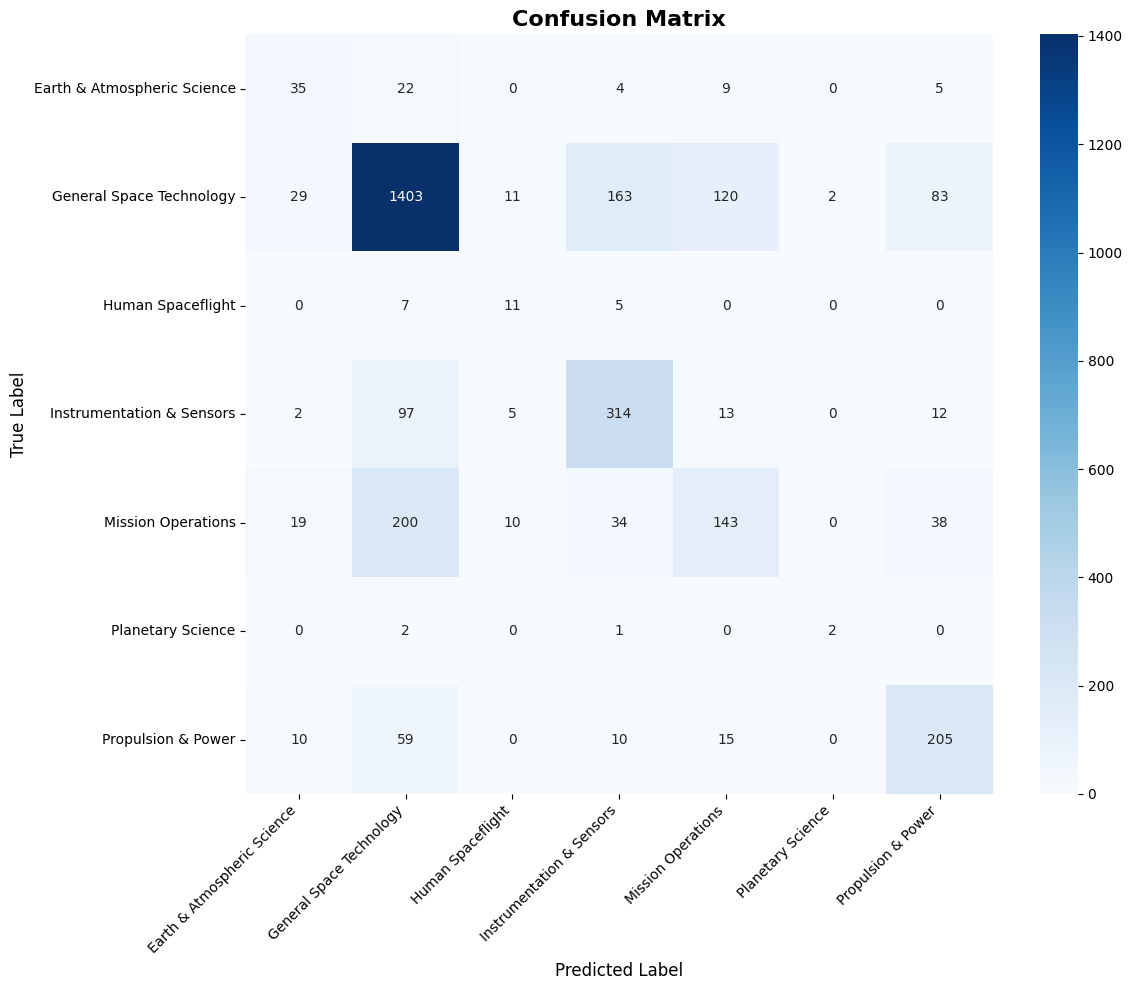

In [14]:
# Cell 11: Detailed Model Evaluation
print("FINAL MODEL EVALUATION:")
print("="*60 + "\n")

# Overall metrics
print("Overall Metrics:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final, average='weighted', zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_final, average='weighted', zero_division=0):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_final, average='weighted', zero_division=0):.4f}")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test, y_pred_final))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=final_model.classes_,
    yticklabels=final_model.classes_
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Cell 12: Feature Importance Analysis
print("TOP FEATURES PER CATEGORY:")
print("="*60 + "\n")

if hasattr(final_model, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()
    
    for i, category in enumerate(final_model.classes_):
        # Get coefficients for this category
        coef = final_model.coef_[i]
        top_indices = coef.argsort()[-10:][::-1]
        top_features = [feature_names[idx] for idx in top_indices]
        
        print(f"{category}:")
        print(f"  Top features: {', '.join(top_features)}\n")

TOP FEATURES PER CATEGORY:

Earth & Atmospheric Science:
  Top features: carbon, monopropellant, aircraft, removal, co2, air, green, dep, revitalization, hydrazine

General Space Technology:
  Top features: laser, lidar, robot, robotic, lithium, structural, prediction, antenna, models, computational

Human Spaceflight:
  Top features: wearable, human, human factors, sensor, monitor, sa, procedure, heart rate, peripheral, factors

Instrumentation & Sensors:
  Top features: detector, detectors, sensors, sensor, sensitivity, imaging, nde, arrays, cryocooler, instrument

Mission Operations:
  Top features: mirror, mirrors, shielding, propellant, electrolysis, radiation shielding, oxygen, plss, valve, display

Planetary Science:
  Top features: sterilization, planetary protection, contamination, contamination control, plates, coating process, chiral, mars, protection, task

Propulsion & Power:
  Top features: propulsion, solar, thruster, power, thrusters, ntp, solar cells, conversion, conve

In [16]:
# Cell 13: Build Advanced Prediction Function
def predict_abstract_advanced(input_text, return_probabilities=True):
    """
    Enhanced prediction function with comprehensive analysis
    """
    # Clean text
    clean = clean_text_advanced(input_text)
    
    # Vectorize
    vec = vectorizer.transform([clean])
    
    # Predict
    predicted_label = final_model.predict(vec)[0]
    
    # Get probabilities if model supports it
    if hasattr(final_model, 'predict_proba'):
        probs = final_model.predict_proba(vec)[0]
    elif hasattr(final_model, 'decision_function'):
        # For SVM, convert decision function to pseudo-probabilities
        decision = final_model.decision_function(vec)[0]
        # Simple softmax
        exp_scores = np.exp(decision - np.max(decision))
        probs = exp_scores / exp_scores.sum()
    else:
        probs = np.zeros(len(final_model.classes_))
        probs[list(final_model.classes_).index(predicted_label)] = 1.0
    
    classes = final_model.classes_
    confidence = probs[list(classes).index(predicted_label)] * 100
    
    # Category probabilities
    category_probs = {
        classes[i]: round(probs[i]*100, 2)
        for i in range(len(classes))
    }
    category_probs = dict(sorted(category_probs.items(), key=lambda x: x[1], reverse=True))
    
    # Top keywords from input
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = vec.toarray()[0]
    top_keyword_indices = tfidf_scores.argsort()[-10:][::-1]
    top_keywords = [feature_names[i] for i in top_keyword_indices if tfidf_scores[i] > 0]
    
    # Find similar abstracts
    similarities = cosine_similarity(vec, X_train_tfidf)[0]
    top_similar_indices = similarities.argsort()[-3:][::-1]
    
    similar_abstracts = []
    for idx in top_similar_indices:
        train_idx = X_train.index[idx]
        similar_abstracts.append({
            'title': df_clean.loc[train_idx, 'title'],
            'category': df_clean.loc[train_idx, 'label'],
            'similarity': round(similarities[idx] * 100, 2)
        })
    
    # Domain overlap (top 3 likely categories)
    top_3_categories = sorted(category_probs.items(), key=lambda x: x[1], reverse=True)[:3]
    detected_domains = [cat for cat, prob in top_3_categories if prob > 10]
    
    # Generate summary (first 2 sentences)
    sentences = [s.strip() for s in input_text.split('.') if len(s.strip()) > 20]
    summary = '. '.join(sentences[:2]) + '.' if sentences else input_text[:200] + '...'
    
    # Trend tags based on keywords
    trends = []
    trend_keywords = {
        'Mars Exploration': ['mars', 'martian', 'rover'],
        'Lunar Science': ['lunar', 'moon'],
        'Spectroscopy': ['spectrometer', 'spectral', 'spectrum'],
        'Remote Sensing': ['remote', 'sensing', 'satellite'],
        'Climate Research': ['climate', 'atmospheric', 'weather'],
        'Space Technology': ['spacecraft', 'satellite', 'mission'],
        'Astrophysics': ['stellar', 'galaxy', 'cosmic', 'universe']
    }
    
    clean_lower = clean.lower()
    for trend, keywords in trend_keywords.items():
        if any(kw in clean_lower for kw in keywords):
            trends.append(trend)
    
    # Readability level
    word_count = len(clean.split())
    if word_count > 150:
        readability = "Advanced Scientific"
    elif word_count > 80:
        readability = "Intermediate"
    else:
        readability = "Basic"
    
    # Technical complexity score (based on vocabulary diversity)
    unique_words = len(set(clean.split()))
    vocab_diversity = unique_words / word_count if word_count > 0 else 0
    complexity_score = min(100, int(vocab_diversity * 150))
    
    return {
        'Predicted Category': predicted_label,
        'Confidence': round(confidence, 2),
        'Category Probabilities': category_probs,
        'Top Keywords': top_keywords[:10],
        'Similar Abstracts': similar_abstracts,
        'Detected Domains': detected_domains,
        'Summary': summary,
        'Trend Tags': trends if trends else ['General Space Science'],
        'Readability Level': readability,
        'Complexity Score': complexity_score,
        'Word Count': word_count,
        'Vocabulary Diversity': round(vocab_diversity, 3)
    }

In [17]:
# Cell 14: Test Prediction Function
test_abstracts = [
    """
    This study analyzes the mineral composition of the Martian surface using
    spectrometer data collected during Mars exploration missions. Advanced
    spectroscopic techniques reveal the presence of various minerals including
    olivine, pyroxene, and hydrated silicates.
    """,
    """
    Development of a next-generation propulsion system utilizing solar electric
    power for deep space missions. The system incorporates high-efficiency ion
    thrusters and advanced power management electronics.
    """,
    """
    Investigation of atmospheric dynamics and cloud formation patterns on Earth
    using satellite-based remote sensing instruments and climate modeling techniques.
    """
]

for i, abstract in enumerate(test_abstracts, 1):
    print(f"\n{'='*70}")
    print(f"TEST ABSTRACT {i}")
    print('='*70)
    print(f"\n{abstract.strip()}\n")
    print('='*70)
    
    result = predict_abstract_advanced(abstract)
    
    print(f"Predicted Category: {result['Predicted Category']}")
    print(f"Confidence: {result['Confidence']:.2f}%")
    print(f"Complexity Score: {result['Complexity Score']}/100")
    
    print("\nTop 3 Category Probabilities:")
    for cat, prob in list(result['Category Probabilities'].items())[:3]:
        print(f"  {cat:<30} → {prob:>6.2f}%")
    
    print(f"\nTop Keywords: {', '.join(result['Top Keywords'][:5])}")
    print(f"Trend Tags: {', '.join(result['Trend Tags'])}")
    print(f"Readability: {result['Readability Level']}")
    
    print("\nSimilar Abstracts:")
    for j, sim in enumerate(result['Similar Abstracts'], 1):
        print(f"  {j}. {sim['title'][:60]}... ({sim['similarity']:.1f}% match)")


TEST ABSTRACT 1

This study analyzes the mineral composition of the Martian surface using
    spectrometer data collected during Mars exploration missions. Advanced
    spectroscopic techniques reveal the presence of various minerals including
    olivine, pyroxene, and hydrated silicates.

Predicted Category: General Space Technology
Confidence: 26.53%
Complexity Score: 100/100

Top 3 Category Probabilities:
  General Space Technology       →  26.53%
  Mission Operations             →  15.61%
  Planetary Science              →  12.54%

Top Keywords: silicates, analyzes, martian surface, mars exploration, reveal
Trend Tags: Mars Exploration, Spectroscopy, Space Technology
Readability: Basic

Similar Abstracts:
  1. Electrostatic Spectrometer for Mars Rover Wheel... (19.6% match)
  2. Biological Augmentation of Off-World Regolith using Aeroponi... (19.0% match)
  3. Shielded Mars Balloon Launcher (SMBL), Phase I... (17.1% match)

TEST ABSTRACT 2

Development of a next-generation propul

In [18]:
# Cell 15: Save Model and Vectorizer
print("\nSAVING MODEL AND COMPONENTS:")
print("="*60)

# Create timestamp for versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_filename = f'nasa_classifier_model_{timestamp}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"✓ Model saved as: {model_filename}")

# Save vectorizer
vectorizer_filename = f'tfidf_vectorizer_{timestamp}.pkl'
with open(vectorizer_filename, 'wb') as f:
    pickle.dump(vectorizer, f)
print(f"✓ Vectorizer saved as: {vectorizer_filename}")

# Save label encoder info
label_info = {
    'classes': final_model.classes_.tolist(),
    'n_classes': len(final_model.classes_),
    'training_date': timestamp
}
label_filename = f'label_info_{timestamp}.pkl'
with open(label_filename, 'wb') as f:
    pickle.dump(label_info, f)
print(f"✓ Label info saved as: {label_filename}")

# Save training statistics
stats = {
    'total_samples': len(df_clean),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'best_model': best_model_name,
    'final_accuracy': accuracy_score(y_test, y_pred_final),
    'final_f1': f1_score(y_test, y_pred_final, average='weighted'),
    'categories': final_model.classes_.tolist()
}
stats_filename = f'training_stats_{timestamp}.pkl'
with open(stats_filename, 'wb') as f:
    pickle.dump(stats, f)
print(f"✓ Training stats saved as: {stats_filename}")

print("\n✓ All components saved successfully!")


SAVING MODEL AND COMPONENTS:
✓ Model saved as: nasa_classifier_model_20260111_113647.pkl
✓ Vectorizer saved as: tfidf_vectorizer_20260111_113647.pkl
✓ Label info saved as: label_info_20260111_113647.pkl
✓ Training stats saved as: training_stats_20260111_113647.pkl

✓ All components saved successfully!


In [19]:
# Cell 16: Create Interactive Prediction Interface
def interactive_classify():
    """Interactive function for classifying custom abstracts"""
    print("\n" + "="*70)
    print("NASA SPACE MISSION ABSTRACT CLASSIFIER")
    print("="*70)
    print("\nEnter your abstract below (press Enter twice to classify):")
    print("-"*70)
    
    lines = []
    while True:
        line = input()
        if line:
            lines.append(line)
        else:
            break
    
    user_input = ' '.join(lines)
    
    if not user_input.strip():
        print("⚠ No input provided!")
        return
    
    result = predict_abstract_advanced(user_input)
    
    print("\n" + "="*70)
    print("CLASSIFICATION RESULTS")
    print("="*70)
    print(f"\n🎯 Predicted Category: {result['Predicted Category']}")
    print(f"📊 Confidence: {result['Confidence']:.2f}%")
    print(f"📈 Complexity Score: {result['Complexity Score']}/100")
    print(f"📝 Word Count: {result['Word Count']}")
    print(f"📚 Readability: {result['Readability Level']}")
    
    print("\n" + "-"*70)
    print("PROBABILITY DISTRIBUTION:")
    print("-"*70)
    for cat, prob in list(result['Category Probabilities'].items())[:5]:
        bar = "█" * int(prob/2)
        print(f"{cat:<30} {bar} {prob:>6.2f}%")
    
    print("\n" + "-"*70)
    print(f"KEY TERMS: {', '.join(result['Top Keywords'][:8])}")
    print(f"TRENDS: {', '.join(result['Trend Tags'])}")
    
    print("\n" + "-"*70)
    print("SIMILAR RESEARCH:")
    print("-"*70)
    for i, sim in enumerate(result['Similar Abstracts'], 1):
        print(f"{i}. {sim['title'][:65]}")
        print(f"   Category: {sim['category']} | Similarity: {sim['similarity']}%")

# Uncomment to run interactive mode
# interactive_classify()

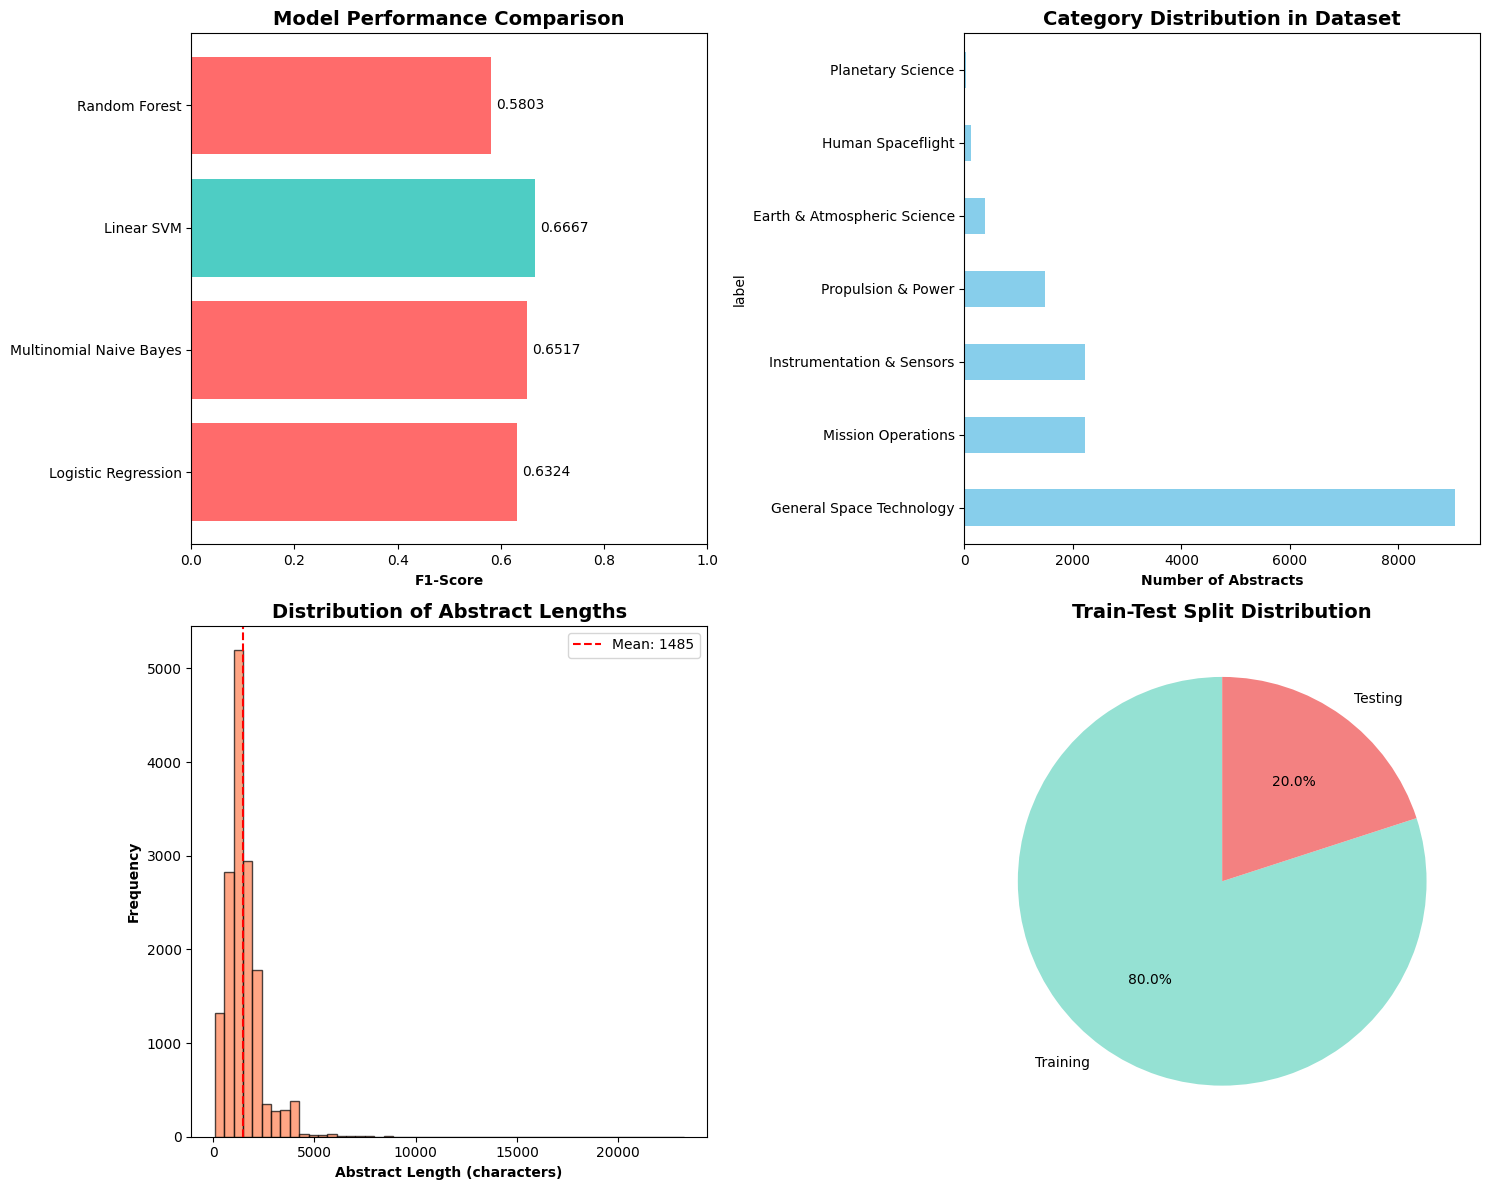


✓ Visualization complete!


In [20]:
# Cell 17: Model Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Comparison
ax1 = axes[0, 0]
models_list = list(results.keys())
f1_scores = [results[m]['f1'] for m in models_list]
colors = ['#FF6B6B' if m != best_model_name else '#4ECDC4' for m in models_list]
ax1.barh(models_list, f1_scores, color=colors)
ax1.set_xlabel('F1-Score', fontweight='bold')
ax1.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax1.set_xlim([0, 1])
for i, v in enumerate(f1_scores):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center')

# 2. Category Distribution
ax2 = axes[0, 1]
label_counts.plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_xlabel('Number of Abstracts', fontweight='bold')
ax2.set_title('Category Distribution in Dataset', fontweight='bold', fontsize=14)

# 3. Abstract Length Distribution
ax3 = axes[1, 0]
ax3.hist(df_clean['abstract_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Abstract Length (characters)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Distribution of Abstract Lengths', fontweight='bold', fontsize=14)
ax3.axvline(df_clean['abstract_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_clean["abstract_length"].mean():.0f}')
ax3.legend()

# 4. Train/Test Split
ax4 = axes[1, 1]
split_data = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Count': [len(X_train), len(X_test)]
})
ax4.pie(split_data['Count'], labels=split_data['Dataset'], autopct='%1.1f%%',
        colors=['#95E1D3', '#F38181'], startangle=90)
ax4.set_title('Train-Test Split Distribution', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


In [21]:
# Cell 18: Summary Report
print("\n" + "="*70)
print("PROJECT SUMMARY REPORT")
print("="*70)
print(f"\nProject: NASA Space Mission Abstract Classification")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nDataset Statistics:")
print(f"  • Total abstracts processed: {len(df_clean):,}")
print(f"  • Number of categories: {df_clean['label'].nunique()}")
print(f"  • Average abstract length: {df_clean['abstract_length'].mean():.0f} characters")

print(f"\nModel Information:")
print(f"  • Best Model: {best_model_name}")
print(f"  • Training Algorithm: TF-IDF + {best_model_name} with GridSearchCV")
print(f"  • Vocabulary Size: {len(vectorizer.vocabulary_):,} features")
print(f"  • Feature Extraction: TF-IDF (1-3 grams)")

print(f"\nPerformance Metrics:")
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, average='weighted')
final_precision = precision_score(y_test, y_pred_final, average='weighted', zero_division=0)
final_recall = recall_score(y_test, y_pred_final, average='weighted', zero_division=0)

print(f"  • Testing Accuracy: {final_accuracy*100:.2f}%")
print(f"  • Weighted F1-Score: {final_f1:.4f}")
print(f"  • Weighted Precision: {final_precision:.4f}")
print(f"  • Weighted Recall: {final_recall:.4f}")

print(f"\nTraining Configuration:")
print(f"  • Train samples: {len(X_train):,} ({len(X_train)/len(X)*100:.0f}%)")
print(f"  • Test samples: {len(X_test):,} ({len(X_test)/len(X)*100:.0f}%)")
print(f"  • Cross-validation folds: 5")
print(f"  • Hyperparameter tuning: Completed")

print(f"\nCategory Performance:")
# Get per-category F1 scores
report_dict = classification_report(y_test, y_pred_final, output_dict=True, zero_division=0)
for category in final_model.classes_:
    if category in report_dict:
        f1_cat = report_dict[category]['f1-score']
        print(f"  • {category}: F1 = {f1_cat:.2f}")

print(f"\nModel Artifacts Saved:")
print(f"  ✓ nasa_classifier_model_{timestamp}.pkl")
print(f"  ✓ tfidf_vectorizer_{timestamp}.pkl")
print(f"  ✓ label_info_{timestamp}.pkl")
print(f"  ✓ training_stats_{timestamp}.pkl")

print("\n" + "="*70)
print("✓ PROJECT COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nThe model is ready for deployment and can classify NASA space mission")
print(f"abstracts into {df_clean['label'].nunique()} scientific categories with {final_accuracy*100:.2f}% accuracy.")


PROJECT SUMMARY REPORT

Project: NASA Space Mission Abstract Classification
Date: 2026-01-11 11:40:03

Dataset Statistics:
  • Total abstracts processed: 15,499
  • Number of categories: 7
  • Average abstract length: 1485 characters

Model Information:
  • Best Model: Linear SVM
  • Training Algorithm: TF-IDF + Linear SVM with GridSearchCV
  • Vocabulary Size: 20,000 features
  • Feature Extraction: TF-IDF (1-3 grams)

Performance Metrics:
  • Testing Accuracy: 68.16%
  • Weighted F1-Score: 0.6774
  • Weighted Precision: 0.6802
  • Weighted Recall: 0.6816

Training Configuration:
  • Train samples: 12,399 (80%)
  • Test samples: 3,100 (20%)
  • Cross-validation folds: 5
  • Hyperparameter tuning: Completed

Category Performance:
  • Earth & Atmospheric Science: F1 = 0.41
  • General Space Technology: F1 = 0.78
  • Human Spaceflight: F1 = 0.37
  • Instrumentation & Sensors: F1 = 0.64
  • Mission Operations: F1 = 0.38
  • Planetary Science: F1 = 0.44
  • Propulsion & Power: F1 = 0.64

